### Import Library

In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import string
import re
import scipy.sparse as sp
from collections import Counter, defaultdict
import math

import torch 
import torch.nn as nn
import torch.optim as optim 
from tqdm import tqdm
import random

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

### Part1: Representing Text Data

In [63]:
train = pd.read_csv('train.csv')   
train.head()    

,text,par_id,label
0,"We 're living in times of absolute insanity , ...",1,0
1,"In Libya today , there are countless number of...",2,0
2,White House press secretary Sean Spicer said t...,3,0
3,Council customers only signs would be displaye...,4,0
4,""" Just like we received migrants fleeing El Sa...",5,0


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8375 entries, 0 to 8374
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8375 non-null   object
 1   par_id  8375 non-null   int64 
 2   label   8375 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 196.4+ KB


In [65]:
train['label'].value_counts()   

0    7572
1     803
Name: label, dtype: int64

In [66]:
label1_index = []
label0_index = []
for i in range(len(train)):
    if train['label'][i] == 1:
        label1_index.append(i)
    else:
        label0_index.append(i)

In [67]:
label0_index[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [68]:
label1_index[:10]

[32, 33, 41, 76, 82, 106, 117, 148, 150, 151]

In [69]:
# np.random.shuffle(label0_index)

#### 1.1 Tokenize:

In [70]:
def tokenize(text):
    return(text.split())    


# Refer to https://pythonprogramming.net/stop-words-nltk-tutorial/
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']


def better_tokenize(text):
    text = str(text)
    text = text.lower().replace('\n', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    text = re.sub(r'<[^<>]*>', '', text) 
    tokens = text.split()
    tokens = [token for token in tokens if (token not in stop_words and len(token) > 2)] 
    return(tokens)

In [71]:
# better_tokenize("Apart from Pakistan and hosts England , Bangladesh disabled cricket team will also participate in the tournament . <h> Shahid Afridi bags 11 Man of the Match awards in T20Is ( Most by any player ) <h> Ab De villiers bagged a pair for the first time in his Test career <h> Super Gossip")

#### 1.2 Building the Term-Document Matrix

In [72]:
def to_sparse_tensor(sp_matrix):
    sp_matrix = sp_matrix.tocoo()
    indices = torch.LongTensor(np.vstack((sp_matrix.row, sp_matrix.col)))
    val = torch.FloatTensor(sp_matrix.data)
    shape = torch.Size(sp_matrix.shape)
    return torch.sparse_coo_tensor(indices, val, shape)  


# Create term-document matrix
def td_matrix(file, minimun_frequency=2, if_better_tokenize=True): 
    sparse_matrix = defaultdict(Counter)
    doc = pd.read_csv(file)
    for idx, line in enumerate(doc['text']):
        if if_better_tokenize:
            tokens = better_tokenize(line)
        else:
            tokens = tokenize(line)
        terms_count = Counter(tokens)   
        for term, count in terms_count.items():
                sparse_matrix[term][idx] += count  
          
            
    # Remove terms below the minimun frequency
    mf_sparse_matrix = defaultdict(Counter)
    for term in sparse_matrix.keys():
        if sum(sparse_matrix[term].values()) >= minimun_frequency:
            mf_sparse_matrix[term] = sparse_matrix[term]
    words_dict = mf_sparse_matrix.keys()   
    
    # Create a numpy and SciPy matrix
    n = doc.shape[0]
    m = len(words_dict)
    matrix = np.zeros((n, m), dtype=int)
    for idx, term in enumerate(words_dict):
        for doc_idx, count in mf_sparse_matrix[term].items():
            matrix[doc_idx][idx] = count
            
    sparse_matrix_SciPy = sp.csr_matrix(matrix)
    
    train_label_tensor_matrix = torch.Tensor(doc['label'])
    
    return words_dict, to_sparse_tensor(sparse_matrix_SciPy), train_label_tensor_matrix

def dd_matrix(file, words_dict, if_better_tokenize=True):
    doc = pd.read_csv(file)
    # Create a numpy and SciPy matrix
    n = doc.shape[0]
    m = len(words_dict)
    matrix = np.zeros((n, m), dtype=int)
    words_dict = [x for x in words_dict]
    
    for idx, line in enumerate(doc['text']):
        # if idx % 100 == 0:
        #     print("Processing: ", idx)
        if if_better_tokenize:
            tokens = better_tokenize(line)
        else:
            tokens = tokenize(line) 
        terms_count = Counter(tokens)   
        for term, count in terms_count.items():
            for i in range(len(words_dict)):
                if term == words_dict[i]:
                    matrix[idx][i] += count
                    
    dev_sparse_matrix_SciPy = sp.csr_matrix(matrix)
    
    if 'label' in doc.columns:  
        dev_label_tensor_matrix = torch.Tensor(doc['label'])
        return to_sparse_tensor(dev_sparse_matrix_SciPy), dev_label_tensor_matrix
    else:
        return to_sparse_tensor(dev_sparse_matrix_SciPy)

### Part 3: Logistic Regression: Pytorch

In [73]:
class LogisticRegression(nn.Module):
    def __init__(self, 
                 in_dim, 
                 out_dim=1,
                 epochs=1,
                 lr=5e-2,
                 opt = 0,
                 step_interval=50,
                 total_steps = 1000,
                 l2_penalty = 0,
                 p_threshold = 0.5
                ):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)
        self.threshold = p_threshold
        self.epochs = epochs
        self.lr = lr
        self.l2_penalty = l2_penalty  
        self.opt= opt  
        self.function_loss = torch.nn.BCELoss()
        self.optimizer = [torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.l2_penalty), # opt 0
                            torch.optim.RMSprop(self.parameters(), lr=self.lr, weight_decay=self.l2_penalty), # opt 1
                                torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2_penalty)]  # opt 2
        self.loss_list = []
        self.f1_list = []
        self.step_list = []
        self.label1_score_investigate = []
        self.total_steps = total_steps  
        self.step_interval = step_interval

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
    
    # create patch of size-3 or 5  
    # which contain two/ three indexes of label0 and one/two index of label1                  
    def pack_patches(self, label0_index, label1_index): 
        patches = []
        # patches.append(random.choice(label0_index))
        patches.append(random.choice(label0_index))
        patches.append(random.choice(label0_index))
        patches.append(random.choice(label1_index))  
        # patches.append(random.choice(label1_index)) 
        np.random.shuffle(patches)
        return patches


    def train_model(self, X, y, X_dev, y_dev):
        current_steps = 0
        # stdv = 1. / math.sqrt(self.linear.weight.size(1))
        # self.linear.weight.data.uniform_(-stdv, stdv)
        for i in range(self.epochs):
            current_steps = 0
            while (current_steps < self.total_steps):   
                order = np.arange(X.shape[0]) if self.total_steps >= X.shape[0] else np.arange(self.total_steps)
                patched_order = []
                for j in range(0, len(order), 3):
                    patched_order += self.pack_patches(label0_index, label1_index)
                
                # for i in range(10):
                #     patched_order += label1_index
                
                self.train()
                for idx in tqdm(patched_order):
                    current_steps += 1
                    
                    self.optimizer[self.opt].zero_grad()
                    outputs = self(X[idx])
                    # if outputs.squeeze() >= self.threshold:
                    #     self.label1_score_investigate.append(outputs.squeeze().item())
                    loss = self.function_loss(outputs.squeeze(), y[idx])
                    
                    loss.backward()
                    self.optimizer[self.opt].step()
                    
                    
                    if current_steps % self.step_interval == 0:
                        self.step_list.append((len(self.step_list) + 1) * self.step_interval)
                        self.eval()
                        with torch.no_grad():
                            y_pred = self(X_dev)
                            self.loss_list.append(self.function_loss(y_pred.squeeze(), y_dev).item())
                            self.f1_list.append(f1_score((y_pred.squeeze()>=self.threshold).int(), y_dev.squeeze()))
                            
                             
    def predict(self, X_dev, y_dev):
        self.eval()
        with torch.no_grad():
            self.label1_score_investigate = []
            y_pred = self(X_dev)
            predicted_result = y_pred.squeeze().tolist()
            result_list = y_dev.tolist()
            for i in range(len(result_list)):
                if result_list[i] == 1:
                    self.label1_score_investigate.append(predicted_result[i])
            return accuracy_score((y_pred.squeeze()>=self.threshold).int(), y_dev)

#### Training and Experiments

In [74]:
word_dict, X, y = td_matrix("train.csv")
# tt = torch.tensor([0.1, 0.4, 0.49, 0.6])
# (tt > 0.4).int()

In [75]:
X

tensor(indices=tensor([[   0,    0,    0,  ..., 8374, 8374, 8374],
                       [   0,    1,    2,  ..., 3973, 6033, 8426]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(8375, 13167), nnz=172055, layout=torch.sparse_coo)

In [76]:
X_dev, y_dev = dd_matrix("dev.csv", word_dict)

In [77]:
# create dataframe with word_dict as column and X as values
df_train = pd.DataFrame(X.to_dense().numpy(), columns=word_dict)
df_train.head()
# for i in range(df_train.shape[1]):
#     if df_train.iloc[0,i] != 0:
#         print(df_train.columns[i], df_train.iloc[0,i])

,living,times,absolute,insanity,pretty,sure,people,aware,waking,every,...,ghiz,myers,moria,mendicity,bradley,somtaki,annan,residual,bulleh,essentials
0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
X[0]

tensor(indices=tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 51]]),
       values=tensor([1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(13167,), nnz=52, layout=torch.sparse_coo)

In [79]:
# df_dev = pd.DataFrame(X_dev.to_dense().numpy(), columns=word_dict)  
# # print colume name if the value is not 0 for the first row
# for i in range(df_dev.shape[1]):
#     if df_dev.iloc[0,i] != 0:
#         print(df_dev.columns[i], df_dev.iloc[0,i])

#### 3.1 Check if work 
- Like you did for the numpy code, train your model for a total of 1000 steps (i.e., only showing it 1000 randomly sampled documents) and report the loss after each 20 steps. This should verify that the loss is going down.

In [80]:
model1 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 20,
    epochs = 1,
    lr = 2e-2,
    total_steps = 1000,
)

model1.train_model(X, y, X_dev, y_dev)

100%|██████████| 1002/1002 [00:00<00:00, 2884.44it/s]


Text(0.5, 1.0, 'Running Loss vs. Steps')

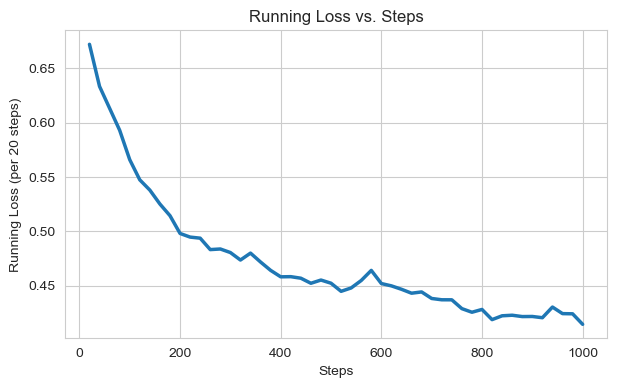

In [81]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=model1.step_list, y=model1.loss_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 20 steps)")
plt.title("Running Loss vs. Steps")

Text(0.5, 1.0, 'F1 score vs. Steps')

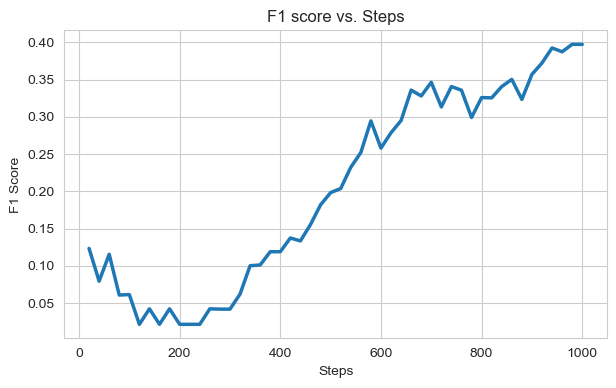

In [82]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=model1.step_list, y=model1.f1_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 score vs. Steps")

#### 3.2 Step Interval = 50; Epochs = 1; Whole Train Set
- Once you’re satisfied that the model is working, train your model for at least 1 epoch and compute (and save) both (1) the loss every 50 steps and (2) the F1 score of the model on the development data.


In [83]:
model2 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    opt = 0
)

model2.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3430.42it/s]


Text(0.5, 0.8, 'Step Interval = 50; Epochs = 5; Whole Train Set')

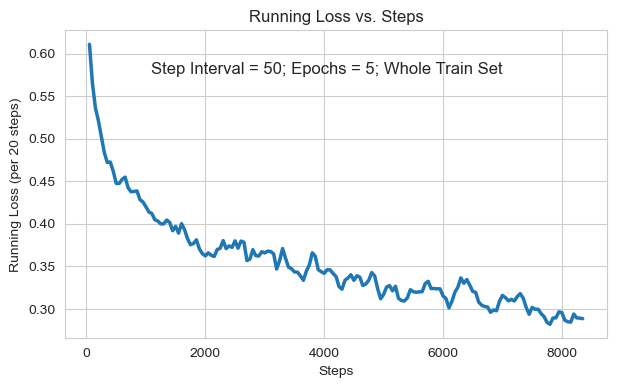

In [84]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=model2.step_list, y=model2.loss_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 20 steps)")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 5; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

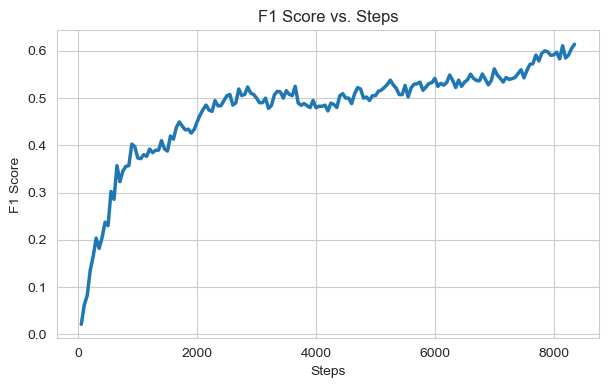

In [85]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=model2.step_list, y=model2.f1_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")


In [86]:
model2.predict(X_dev, y_dev)

0.9264565425023877

#### 3.3 Loss and F1 score vs. L2 penalty
- Let’s see what are the effects of adding regularization. PyTorch builds in regularization through the weight decay argument to most Optimizer classes (including the one you use, SGD. Let’s see what the effect is for setting the L2 penalty to 0 (default), 0.001, and 0.1. For each L2 penalty value, train the model for 1 epoch total and plot the loss and F1 score on the development set every 50 steps using one line for each L2 value (use separate plots for F1 vs. Loss). In a few sentences, describe what you see: What effect does L2 have on the convergence speed and overall model performance?

In [87]:
# L2 penalty = 0
l2_model1 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=0
)

l2_model1.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3056.27it/s]


In [88]:
# L2 penalty = 0.001
l2_model2 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=1e-3
)

l2_model2.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3502.59it/s]


In [89]:
# L2 penalty = 0.1
l2_model3 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=1e-1
)

l2_model3.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3437.31it/s]


In [90]:
l2_df = pd.DataFrame({"Steps": l2_model1.step_list+l2_model2.step_list+l2_model3.step_list,
                      "Loss": l2_model1.loss_list+l2_model2.loss_list+l2_model3.loss_list,
                      "F1": l2_model1.f1_list+l2_model2.f1_list+l2_model3.f1_list,
                      "L2 Penalty": ["0.0"]*len(l2_model1.step_list)+["0.001"]*len(l2_model2.step_list)+["0.1"]*len(l2_model3.step_list)})

In [91]:
l2_df

,Steps,Loss,F1,L2 Penalty
0,50,0.622039,0.082474,0.0
1,100,0.580667,0.080808,0.0
2,150,0.537971,0.000000,0.0
3,200,0.510334,0.021277,0.0
4,250,0.500199,0.000000,0.0
...,...,...,...,...
496,8150,0.488311,0.294574,0.1
497,8200,0.483245,0.256000,0.1
498,8250,0.478610,0.208696,0.1
499,8300,0.487917,0.306452,0.1


Text(0.5, 0.8, 'Step Interval = 50; Epochs = 1; Whole Train Set')

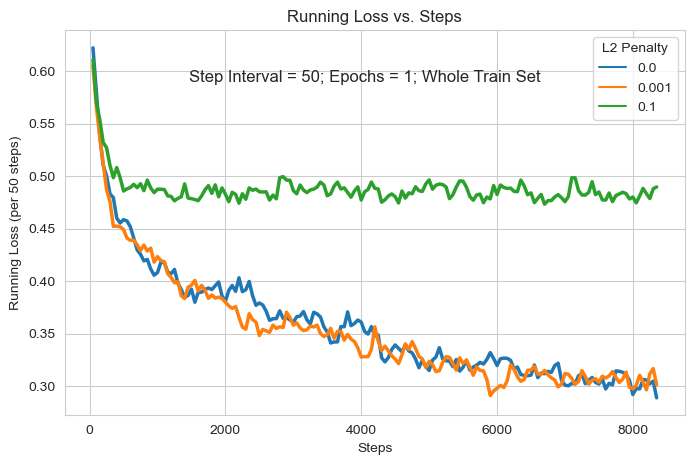

In [92]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="Loss", linewidth=2.5, hue="L2 Penalty", data=l2_df)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 50 steps)")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 1; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

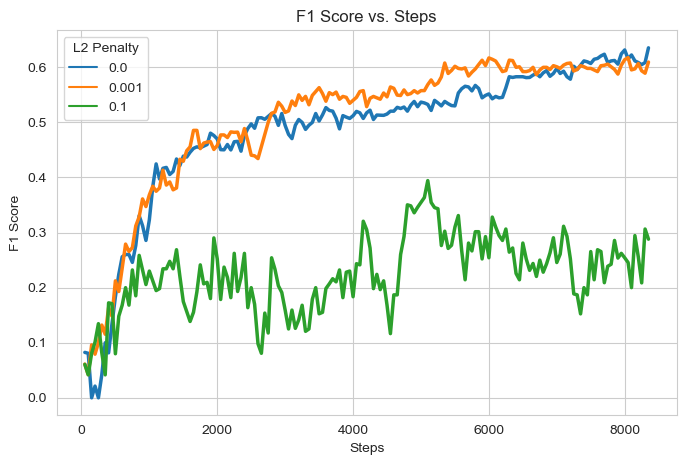

In [93]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="F1", linewidth=2.5, hue="L2 Penalty", data=l2_df)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")


#### Conclusion:
- L2 penalty = 0.0 and 0.001 performs with good training quality while l2_penalty = 0.1 will poison the Loss and F1 scores.

#### 3.4 SGD, RMSprop and AdamW optimizer

In [123]:
# SGD optimizer
SGD_model = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=0,
    opt=0
)

SGD_model.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3096.90it/s]


In [124]:
# SGD optimizer
RMSprop_model = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=0,
    opt=1
)

RMSprop_model.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 2798.69it/s]


In [125]:
# SGD optimizer
AdamW_model = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
    l2_penalty=0,
    opt=2
)

AdamW_model.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 2905.13it/s]


In [126]:
Opt_df = pd.DataFrame({"Steps": SGD_model.step_list+RMSprop_model.step_list+AdamW_model.step_list,
                      "Loss": SGD_model.loss_list+RMSprop_model.loss_list+AdamW_model.loss_list,
                      "F1": SGD_model.f1_list+RMSprop_model.f1_list+AdamW_model.f1_list,
                      "Optimizer": ["SGD"]*len(SGD_model.step_list)+["RMSprop"]*len(RMSprop_model.step_list)+["AdamW"]*len(AdamW_model.step_list)})

Text(0.5, 0.8, 'Step Interval = 50; Epochs = 1; Whole Train Set')

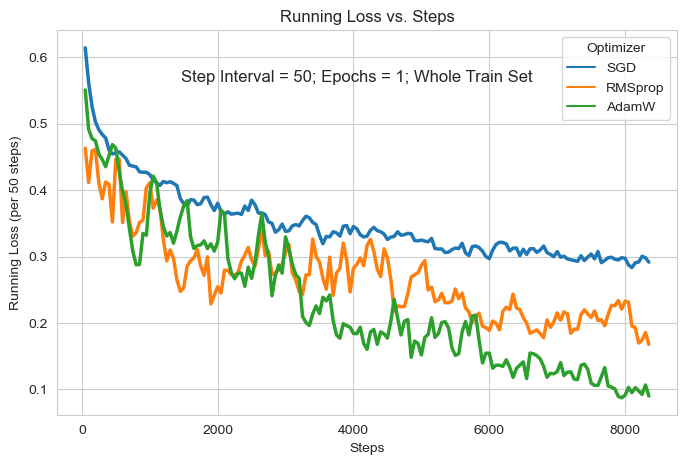

In [127]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="Loss", linewidth=2.5, hue="Optimizer", data=Opt_df)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 50 steps)")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 1; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

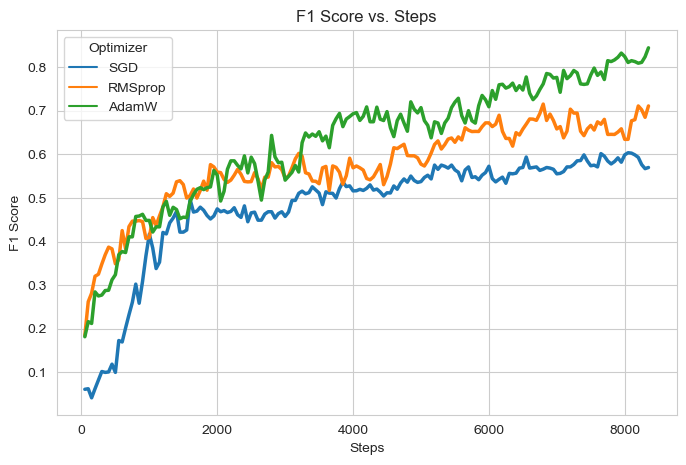

In [128]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="F1", linewidth=2.5, hue="Optimizer", data=Opt_df)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")

#### Conclusion
- RMSprop and AdamW can't effectively reduce the loss and converge in the end; For F1 scores, RMSprop and AdamW increse quicker than SGD at the first while SGD will catch up after 4000 steps and surpass in the end.

#### 3.5 Better Tokenize vs. Simple Tokenize

In [100]:
word_dict_simple, X_simple, y_simple = td_matrix("train.csv", if_better_tokenize=False)
X_dev_simple, y_dev_simple = dd_matrix("dev.csv", word_dict_simple, if_better_tokenize=False)

In [101]:
better_tokenize_model = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X.shape[0],
)

better_tokenize_model.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3224.91it/s]


In [102]:
simple_tokenize_model = LogisticRegression(
    in_dim = len(word_dict_simple), 
    step_interval = 50,
    epochs = 1,
    lr = 2e-2,
    total_steps = X_simple.shape[0],
)

simple_tokenize_model.train_model(X_simple, y_simple, X_dev_simple, y_dev_simple)

100%|██████████| 8376/8376 [00:03<00:00, 2562.18it/s]


In [103]:
if_better_tokenize_df = pd.DataFrame({"Steps": better_tokenize_model.step_list+simple_tokenize_model.step_list,
                      "Loss": better_tokenize_model.loss_list+simple_tokenize_model.loss_list,
                      "F1": better_tokenize_model.f1_list+simple_tokenize_model.f1_list,
                      "Simple_or_Better": ["Better"]*len(better_tokenize_model.step_list)+["Simple"]*len(simple_tokenize_model.step_list)})

Text(0.5, 0.8, 'Step Interval = 50; Epochs = 1; Whole Train Set')

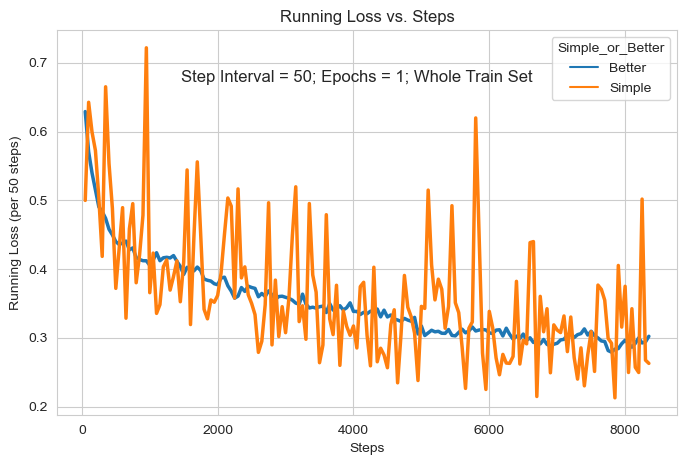

In [104]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="Loss", linewidth=2.5, hue="Simple_or_Better", data=if_better_tokenize_df)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 50 steps)")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 1; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

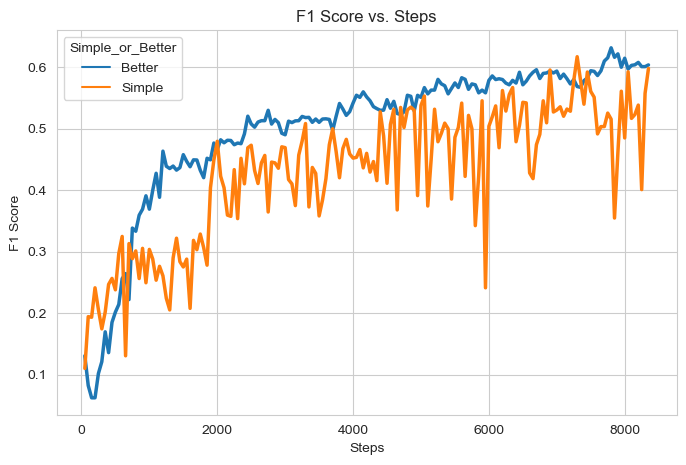

In [105]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="F1", linewidth=2.5, hue="Simple_or_Better", data=if_better_tokenize_df)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")

#### Conclusion: 
- It shows that better tokenize is more stable and converges better.

#### 3.5 Learning Rates

In [129]:
# lr = 2e-2
lr_model1 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-2,
    total_steps = X.shape[0],
)

lr_model1.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3202.13it/s]


In [130]:
# lr = 2e-3
lr_model2 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-3,
    total_steps = X.shape[0],
)

lr_model2.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 2966.65it/s]


In [131]:
# lr = 2e-4
lr_model3 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-4,
    total_steps = X.shape[0],
)

lr_model3.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3202.92it/s]


In [132]:
# lr = 2e-5
lr_model4 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-5,
    total_steps = X.shape[0],
)

lr_model4.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3532.41it/s]


In [133]:
# lr = 2e-1
lr_model5 = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-1,
    total_steps = X.shape[0],
)

lr_model5.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3495.23it/s]


In [134]:
lr_df = pd.DataFrame({"Steps": lr_model1.step_list+lr_model2.step_list+lr_model3.step_list+lr_model4.step_list+lr_model5.step_list,
                      "Loss": lr_model1.loss_list+lr_model2.loss_list+lr_model3.loss_list+lr_model4.loss_list+lr_model5.loss_list,
                      "F1": lr_model1.f1_list+lr_model2.f1_list+lr_model3.f1_list+lr_model4.f1_list+lr_model5.f1_list,
                      "lr": ["2e-2"]*len(lr_model1.step_list)+["2e-3"]*len(lr_model2.step_list)+["2e-4"]*len(lr_model3.step_list)+["2e-5"]*len(lr_model4.step_list)+["2e-1"]*len(lr_model5.step_list)})

Text(0.5, 0.8, 'Step Interval = 50; Epochs = 1; Whole Train Set')

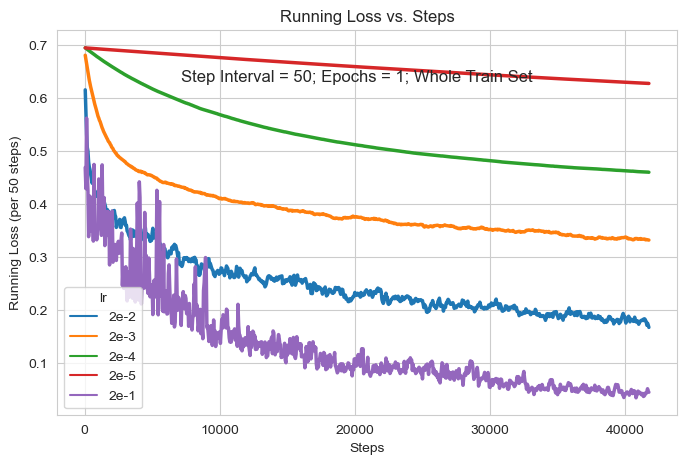

In [135]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="Loss", linewidth=2.5, hue="lr", data=lr_df)
plt.xlabel("Steps")
plt.ylabel("Running Loss (per 50 steps)")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 1; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

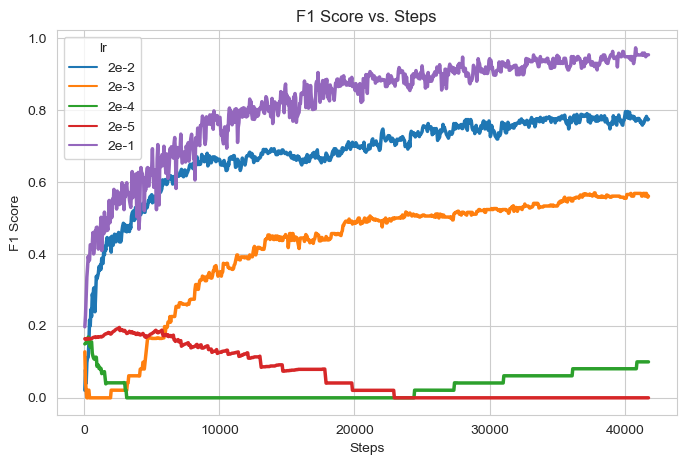

In [136]:
plt.figure(figsize=(8, 5))
sns.lineplot(x="Steps", y="F1", linewidth=2.5, hue="lr", data=lr_df)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")

#### Conclusion:
- It seems that 2e-2 works the best. When lr is too low, F1 score will die to 0.

#### 3.6 Choose the best model

In [114]:
# word_dict, X, y = td_matrix("train.csv")
# X_dev, y_dev = dd_matrix("dev.csv", word_dict)

In [115]:
# lr = 2e-2
best_model = LogisticRegression(
    in_dim = len(word_dict), 
    step_interval = 50,
    epochs = 5,
    lr = 2e-2,
    total_steps = X.shape[0],
    p_threshold=0.5,
    opt=0
)

best_model.train_model(X, y, X_dev, y_dev)

100%|██████████| 8376/8376 [00:02<00:00, 3354.93it/s]


In [116]:
# best_model.predict(X_dev, y_dev)
# best_model.label1_score_investigate

Text(0.5, 0.8, 'Step Interval = 50; Epochs = 5; Whole Train Set')

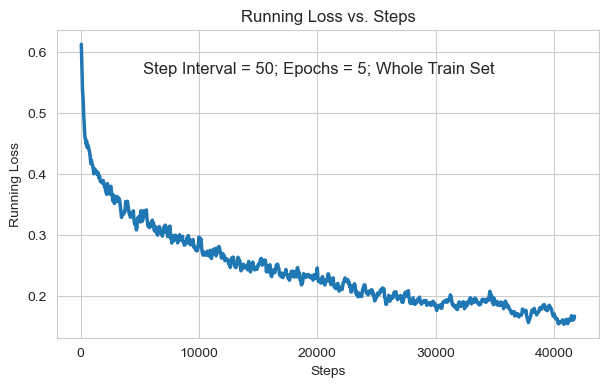

In [117]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=best_model.step_list, y=best_model.loss_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("Running Loss")
plt.title("Running Loss vs. Steps")
plt.suptitle("Step Interval = 50; Epochs = 5; Whole Train Set", y=0.8)

Text(0.5, 1.0, 'F1 Score vs. Steps')

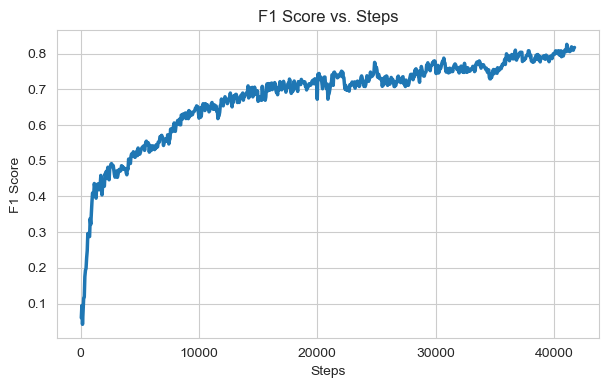

In [118]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=best_model.step_list, y=best_model.f1_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Steps")

In [119]:
X_final = dd_matrix("test.student.csv", word_dict)

In [120]:
X_final.shape

torch.Size([2094, 13167])

In [121]:
y_final = best_model(X_final).round().squeeze()
pair_id = pd.read_csv('test.student.csv')['par_id']
with torch.no_grad():
    final_df = pd.DataFrame({'par_id': pair_id, 'label': y_final.numpy().astype(int)}) 
final_df.to_csv('test.student.predicted.csv', index=False)

In [122]:
best_model.predict(X_dev, y_dev)

0.9627507163323782